## 1. Membrane composition

Takes the trajectories of the 3 replicates and performs:

- Analysis of the lipid composition around the protein (cut-off) during the last 500 ns of each
- Plot it as a donut plot (INSIDE INITIAL, OUTSIDE FINAL)

#### 1.1 Pre-requisites

In [51]:
#Assign variables
trpv = 6
cutoff = 5.5

#Folders
folder = f"../Simulations/TRPV{trpv}"
trajfile_list = [f"{folder}/replica_{r}/Analysis/analysis_centered_step7_production.xtc" for r in [1,2,3]]
topfile_list = [f"{folder}/replica_{r}/Analysis/analysis_step7_coord.gro" for r in [1,2,3]]

#Memory
in_memory=True
in_memory_step=1

In [52]:
#Load required libraries
import MDAnalysis as mda
import os
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
import seaborn as sns
import numpy as np
import pandas as pd
import math

In [53]:
#Create analysis directory
try:
    os.mkdir(f"{folder}/Membrane_composition")
    print(f"Folder 'Membrane_composition' created in {folder}")
except FileExistsError:
    print(f"Could not create folder. Folder 'Membrane_composition' already exists in {folder}")

Could not create folder. Folder 'Membrane_composition' already exists in ../Simulations/TRPV6


#### 1.2 Get initial and final compositions

In [54]:
def get_compositions(top, traj):
    u = mda.Universe(top, traj, in_memory=in_memory, in_memory_step=in_memory_step)

    # Get lipids in system
    global lipid_names
    lipid_names = set(u.select_atoms('name P* or resname CHOL').resnames)

    # Select atoms
    protein = u.select_atoms(f"protein")
    lipids = {lipid:u.select_atoms(f"resname {lipid}") for lipid in lipid_names}

    ### Initial composition ###
    absolute_initial_composition = {lipid:len(list(lipids[lipid].residues.resids)) for lipid in lipid_names}
    relative_initial_composition = {lipid:absolute_initial_composition[lipid]/sum(absolute_initial_composition.values())*100 for lipid in lipid_names}

    ### Enrichment/depletion last 500 ns ###
    absolute_de = {lipid:0 for lipid in lipid_names} #Initialize dictionary
    # Iterate over last 500 ns
    for ts in u.trajectory[-500:]:
        #Get lipids within the cutoff (any bead)
        surr_lipids = list(u.select_atoms(f"resname {' '.join(lipid_names)} and around {cutoff} protein").residues.resnames)
        #Add count to dictionary
        for lipid in lipid_names: 
            absolute_de[lipid] += surr_lipids.count(lipid)
    #Now divide each lipid count by total amount of lipids around the protein during those last 500 ns
    relative_de = {lipid:absolute_de[lipid]/sum(absolute_de.values())*100 for lipid in lipid_names}

    return {"Abs0":absolute_initial_composition, "Rel0":relative_initial_composition, "AbsDE":absolute_de, "RelDE":relative_de}

In [55]:
#Now compute compositions (absolute)
compositions = {f"R{replica}":0 for replica in [1,2,3]}
for i, traj in enumerate(trajfile_list):
    compositions[f"R{i+1}"] = get_compositions(topfile_list[i], traj)
    

/home/apmlab/Projects/Mario/TRPVs/trpv_analysis/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/apmlab/Projects/Mario/TRPVs/trpv_analysis/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/apmlab/Projects/Mario/TRPVs/trpv_analysis/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/apmlab/Projects/Mario/TRPVs/trpv_analysis/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the followi

In [56]:
#Calculate mean accross replicates (two different ways, minimal differences)
#DE: Mean of relative compositions of the 3 replicas
avg_rel_comp_de_1 = np.array([list(compositions[r]["RelDE"].values()) for r in compositions.keys()]).mean(axis=0)
#DE: Relative composition by the sum of absolute numbers for the 3 replicas
avg_rel_comp_de_2 = np.array([list(compositions[r]["AbsDE"].values()) for r in compositions.keys()]).sum(axis=0)/np.array([list(compositions[r]["AbsDE"].values()) for r in compositions.keys()]).sum(axis=0).sum()*100

#Shouldn't be very different
print("Compare averages:")
print(avg_rel_comp_de_1-avg_rel_comp_de_2)


#Initial relative composition  accross 3 replicas (SHOULD BE IDENTICAL)
avg_rel_comp_0_1 = np.array([list(compositions[r]["Rel0"].values()) for r in compositions.keys()]).mean(axis=0)
std_rel_comp_0_1 = np.array([list(compositions[r]["Rel0"].values()) for r in compositions.keys()]).std(axis=0)
#Should be 0 for all lipids (maybe 10e-15 or so due to rounding error)
print("\nCheck deviation between replicas:")
print(std_rel_comp_0_1)

Compare averages:
[-0.00440921 -0.00483664 -0.00168604  0.00618204  0.00540848  0.0024635
  0.00105759 -0.003911    0.00347562 -0.00374434]

Check deviation between replicas:
[3.55271368e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.88178420e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [57]:
#Put in a dataframe
df = pd.DataFrame({"Initial%":avg_rel_comp_0_1, "Final%":avg_rel_comp_de_2}, index=list(lipid_names))
df["DE"] = df["Final%"]/df["Initial%"] #DE index, just in case

#Save the dataframe data
df.to_csv(f"{folder}/Membrane_composition/Final_vs_Initial_TRPV{trpv}.csv")

#### 1.2 Plot the data into a donut plot

Plot the data in a double donut form:

- INNER donut shows initial composition

- OUTER donut shows final composition around the protein

Colors should be the lipid colors used across all the paper.

In [58]:
#Set color variables
lipid_colors = {"CHOL": "#89cff0",
                "POPC": "#cb99c9",
                "PAPC": "#e7c5db",
                "POPE": "#befd73",
                "DIPE": "#77dd77",
                "PAP1": "#ff964f",
                "PAP6": "#ff6961",
                "PAPS": "#fdfd96",
                "POPA": "#ff9899",
                "DPSM": "#836953"}

#Load composition .csv as df
comp_df = pd.read_csv(f"{folder}/Membrane_composition/Final_vs_Initial_TRPV{trpv}.csv", index_col=0)
comp_df = comp_df.reindex(lipid_colors.keys())

In [59]:
comp_df["Final%"]

CHOL    30.128410
POPC    11.349528
PAPC    11.349050
POPE     2.874060
DIPE    13.020248
PAP1     4.552427
PAP6     7.025056
PAPS    10.189199
POPA     0.591634
DPSM     8.920387
Name: Final%, dtype: float64

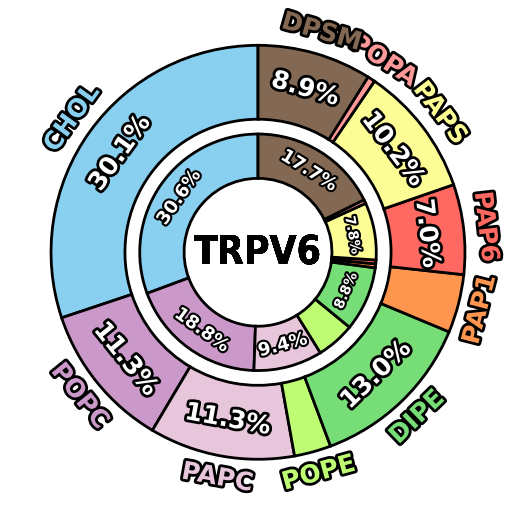

In [60]:
#DOUBLE PIE PLOT

# Text Ring --> texts
fig, ax = plt.subplots()
ax.axis('equal')
texts_comp, labels = ax.pie(comp_df["Final%"].values, radius=1.6, labels=comp_df.index, 
                    colors="w",
                    startangle=90)
plt.setp(texts_comp, width=0.1, edgecolor='black', linewidth=0)

# First Ring (outside) --> final composition around protein
final_comp, _, percs_f = ax.pie(comp_df["Final%"].values, radius=1.4,
                    colors=lipid_colors.values(),
                    startangle=90,
                    autopct='%1.1f%%')
plt.setp(final_comp, width=0.5, edgecolor='black', linewidth=2)

# Second Ring (Inside) --> initial composition
initial_comp, _, percs_i = ax.pie(comp_df["Initial%"].values, radius=0.8, 
                    colors=lipid_colors.values(),
                    startangle=90,
                    autopct='%1.1f%%')
plt.setp(initial_comp, width=0.3, edgecolor='black', linewidth=2)
plt.margins(0,0)

######################################################################
# Define a function to calculate the midpoint coordinates of a wedge
def calculate_midpoint(start_angle, end_angle, radius):
    angle = (start_angle + end_angle) / 2
    x = radius * math.cos(math.radians(angle))
    y = radius * math.sin(math.radians(angle))
    return x, y

#######################################################################
# Customizing labels and percentages
for label, perc_f, perc_i, wedge_ext, wedge_final, wedge_initial in zip(labels, percs_f, percs_i, texts_comp, final_comp, initial_comp):
    #Get midpoijts for each wedge 
    start_angle, end_angle = wedge_ext.theta1, wedge_ext.theta2 #For labels
    start_angle_f, end_angle_f = wedge_final.theta1, wedge_final.theta2 #For percentages final
    start_angle_i, end_angle_i = wedge_initial.theta1, wedge_initial.theta2 #For percentages final

    # RADII MUST BE (donut radii-donut width)//2
    x, y = calculate_midpoint(start_angle, end_angle, 1.55) #Position coord for labels
    xf, yf = calculate_midpoint(start_angle_f, end_angle_f, 1.15) #Position coord for final percentages
    xi, yi = calculate_midpoint(start_angle_i, end_angle_i, 0.65) #Position coord for initial percentages

    #Customizing label
    label.set_color(lipid_colors[label.get_text()])  # Set label color
    label.set_fontsize(18)  # Set label font size
    label.set_fontweight('bold')  # Set label font weight
    label.set_horizontalalignment("center")
    label.set_verticalalignment("center")

    #Customizing % composition initial
    perc_i.set_color("white")  # Set label color
    perc_i.set_fontsize(13)  # Set label font size
    perc_i.set_fontweight('bold')  # Set label font weight
    perc_i.set_horizontalalignment("center")
    perc_i.set_verticalalignment("center")
    #Remove % when is too small
    if float(perc_i.get_text().replace("%","")) < 9: perc_i.set_fontsize(10)  # Set label font size
    if float(perc_i.get_text().replace("%","")) < 5.5: perc_i.set_text("")

    #Customizing % composition final
    perc_f.set_color("white")  # Set label color
    perc_f.set_fontsize(18)  # Set label font size
    perc_f.set_fontweight('bold')  # Set label font weight
    perc_f.set_horizontalalignment("center")
    perc_f.set_verticalalignment("center")
    #Remove % when is too small
    if float(perc_f.get_text().replace("%","")) < 7: perc_f.set_fontsize(12)  # Set label font size
    if float(perc_f.get_text().replace("%","")) < 5.5: perc_f.set_text("")

    
    # Add text outline
    outline_effect = withStroke(linewidth=4, foreground='black')
    label.set_path_effects([outline_effect])
    perc_f.set_path_effects([outline_effect])
    perc_i.set_path_effects([withStroke(linewidth=3, foreground='black')])

    # Rotate each label by a certain angle
    # Calculate the angle in radians using the arctangent function
    angle_rad = math.atan2(5 - 0, 0 - 0) - math.atan2(y - 0, x - 0)
    angle_deg = math.degrees(angle_rad)

    angle_rad_initial = math.atan2(5 - 0, 0 - 0) - math.atan2(yi - 0, xi - 0)
    angle_deg_initial = math.degrees(angle_rad_initial)

    if angle_deg < 0: angle_deg=360+angle_deg
    if angle_deg_initial < 0: angle_deg_initial=360+angle_deg_initial

    #First for labels and final % (same positions)
    if angle_deg >=270 or angle_deg <=90:
        label.set_rotation(360-angle_deg) #Rotate top labels so they are readable
        perc_f.set_rotation(360-angle_deg) #Same as above
    else: 
        label.set_rotation(180-angle_deg) #Same for bottom labels, to avoid them being upside down
        perc_f.set_rotation(180-angle_deg) #Same as above

    #Then for the initial donut (different wegdes)
    if angle_deg_initial >=270 or angle_deg_initial <=90:
        perc_i.set_rotation(360-angle_deg_initial) #Rotate top % so they are readable
    else: 
        perc_i.set_rotation(180-angle_deg_initial) #Same for bottom %, to avoid them being upside down


    # Set the position of the label so that its center aligns with (x, y)
    label.set_position((x, y))
    perc_f.set_position((xf, yf))
    perc_i.set_position((xi, yi))

    #Finally, add trpv text in middle
    center_text = plt.text(0,0,f"TRPV{trpv}", horizontalalignment="center", verticalalignment="center")
    center_text.set_fontsize(28)
    center_text.set_fontweight(1000)
    center_text.set_fontstretch(0)


####  SAVE FIGURE ######
fig.savefig(f"{folder}/Membrane_composition/Composition_donut.svg", bbox_inches="tight")
fig.savefig(f"{folder}/Membrane_composition/Composition_donut.png", dpi=600, bbox_inches="tight")